# 뉴스 요약

# 1. 노드 구현하기

### 1. 데이터 보기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aiffel0038/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows = 100000)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 100000


In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data = data[['Text','Summary']]
data.head()

#랜덤한 3개 샘플 출력
data.sample(15)

,Text,Summary
28911,Most of these seeds sprouted. We thought the p...,good percentage
46750,"I reviewed this already, but apparently I need...",Anisette toast
23196,Puroast Low Acid Coffee Low Acid Coffee French...,Low Acid Coffee
49050,my dog destroys & devours most everything in n...,good treat for destructive dog
13245,I have to say the new offerings are great. the...,i really like it
58029,"My two Cavaliers were constantly scratching, s...",Anti itch aide
36237,We go through cereal pretty quickly so orderin...,Great price for this grownup cereal
49628,I first tasted this tea when my daughter broug...,orange cinammon tea
23763,Our family has liked every other flavored we h...,Not a fan of the Sweet Potato Pop Chips
34469,"This brew is not bitter or too strong, it make...",One of the better cups


### 2. 데이터 전처리하기

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [6]:
data.drop_duplicates(subset = ['Text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 88426


In [7]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [8]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 88425


In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [12]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [13]:
clean_summary = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

/home/aiffel0038/anaconda3/envs/aiffel/lib/python3.7/site-packages/bs4/__init__.py:421: MarkupResemblesLocatorWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [14]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [15]:
data.isnull().sum()

Text        0
Summary    70
dtype: int64

In [16]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 88355


텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


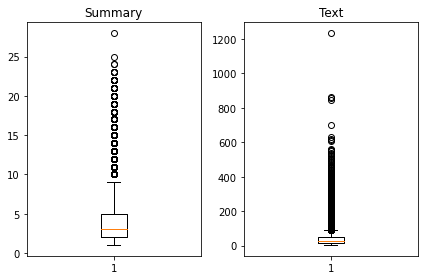

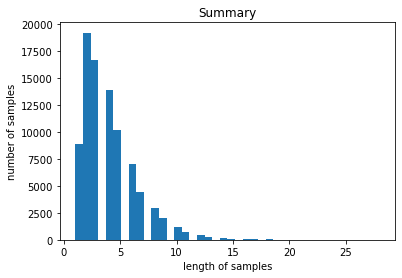

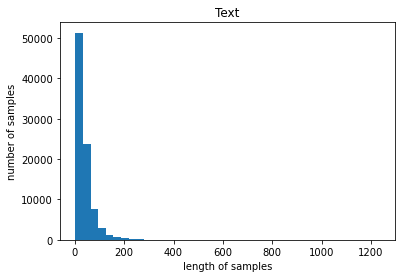

In [17]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
text_max_len = 50
summary_max_len = 8

In [19]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [20]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [21]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 65818


In [22]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [23]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [24]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[39901 44038 41827 ...  7061 57242 13183]


In [25]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [26]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 13163


In [27]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


In [28]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [29]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32026
등장 빈도가 6번 이하인 희귀 단어의 수: 23743
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8283
단어 집합에서 희귀 단어의 비율: 74.13663898082807
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3691881622352238


In [30]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [31]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[82, 912, 740, 314, 45, 252, 4269, 2577, 489, 83, 385, 12, 257], [1116, 8, 2, 463, 2161, 24, 1060, 871, 405, 334, 100, 347, 2928, 142, 624, 480, 294, 3, 8], [24, 176, 77, 288, 44, 147, 426, 2227, 716, 702, 584, 19, 288, 380, 79, 7208, 5473, 4514, 24, 716, 288, 140, 73, 64, 683, 422, 5, 120, 126, 2335, 288, 1547, 29, 184, 774, 6832, 716, 68, 702, 5]]


In [32]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [33]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10491
등장 빈도가 5번 이하인 희귀 단어의 수: 8104
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2387
단어 집합에서 희귀 단어의 비율: 77.24716423601183
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.88430221548949


In [34]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 6, 519, 229], [1, 4, 27, 55, 153], [1, 45, 415], [1, 4, 17], [1, 3, 74]]
target
decoder  [[6, 519, 229, 2], [4, 27, 55, 153, 2], [45, 415, 2], [4, 17, 2], [3, 74, 2]]


In [35]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1266
삭제할 테스트 데이터의 개수 : 328
훈련 데이터의 개수 : 51389
훈련 레이블의 개수 : 51389
테스트 데이터의 개수 : 12835
테스트 레이블의 개수 : 12835


In [36]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

### 3. 모델 설계하기

In [37]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [38]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [39]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [40]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [41]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 4. 모델 훈련하기

In [42]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
201/201 [==============================] - 59s 292ms/step - loss: 2.7115 - val_loss: 2.4191
Epoch 2/50
201/201 [==============================] - 58s 289ms/step - loss: 2.3873 - val_loss: 2.2756
Epoch 3/50
201/201 [==============================] - 58s 288ms/step - loss: 2.2341 - val_loss: 2.1433
Epoch 4/50
201/201 [==============================] - 58s 289ms/step - loss: 2.1183 - val_loss: 2.0706
Epoch 5/50
201/201 [==============================] - 59s 292ms/step - loss: 2.0377 - val_loss: 2.0112
Epoch 6/50
201/201 [==============================] - 58s 290ms/step - loss: 1.9746 - val_loss: 1.9769
Epoch 7/50
201/201 [==============================] - 58s 290ms/step - loss: 1.9216 - val_loss: 1.9431
Epoch 8/50
201/201 [==============================] - 58s 290ms/step - loss: 1.8750 - val_loss: 1.9289
Epoch 9/50
201/201 [==============================] - 58s 290ms/step - loss: 1.8330 - val_loss: 1.9057
Epoch 10/50
201/201 [==============================] - 58s 290ms/step - l

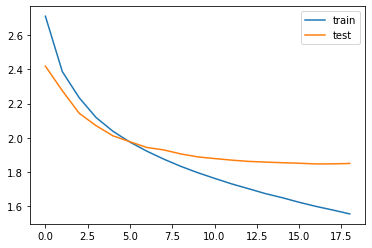

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 5. 인퍼런스 모델 구현하기

In [44]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [45]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [46]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [47]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 6. 모델 테스트하기

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [49]:
for i in range(1, 50):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : bought brand chai years love satisfying different decaf coffee drinking like special treat 
실제 요약 : vanilla decaf sugar free chai 
예측 요약 :  best decaf


원문 : great lower sugar high fiber granola option loved eating handful also sprinkling plain greek yogurt bag last long feel guilty eating 
실제 요약 : by the 
예측 요약 :  great taste


원문 : fair one twins got gas horrible night gas pains garbanzo beans ideal food young babies 
실제 요약 : the beans in it give horrible gas 
예측 요약 :  great product


원문 : carbonation flavor tasted watered calories per soft drink would taste lot better pretty expensive also might consider mixer course defeats purpose healthy rather disappointing 
실제 요약 : better with of 
예측 요약 :  not as good as the cherry


원문 : taste awesome pain unwrap every single one like better sour belts wrapped though 
실제 요약 : delicious but is 
예측 요약 :  great


원문 : anyone explain none adults staff happily gobble meetings eat green ones understand kids people please add pineapple life save

## 7. 추출요약

In [50]:
import requests
from summa.summarizer import summarize

In [51]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [52]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [53]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [54]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [55]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


## 2. news_summary_more 데이터 요약해보기

### 1. 데이터 보기

In [61]:
news_path = os.getenv("HOME") + '/aiffel/news_summarization/data/news_summary_more.csv'
news = pd.read_csv(news_path)
news.head()
print(news.shape)

(98401, 2)


### 2. 데이터 전처리하기

In [60]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', news['headlines'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', news['text'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98280
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [64]:
news.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(news)))

전체 샘플수 : 98360


In [65]:
print(news.isnull().sum())

headlines    0
text         0
dtype: int64


In [66]:
clean_news_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in news['text']:
    clean_news_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_news_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [67]:
clean_news_summary = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in news['headlines']:
    clean_news_summary.append(preprocess_sentence(s, False))

clean_news_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [68]:
news['text'] = clean_news_text
news['headlines'] = clean_news_summary

# 빈 값을 Null 값으로 변환
news.replace('', np.nan, inplace=True)

In [70]:
news.isnull().sum()

headlines    0
text         0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


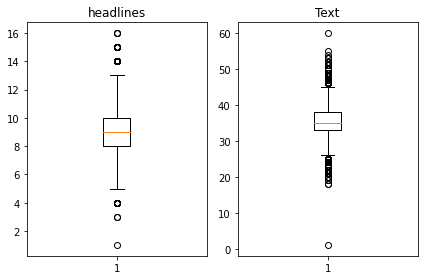

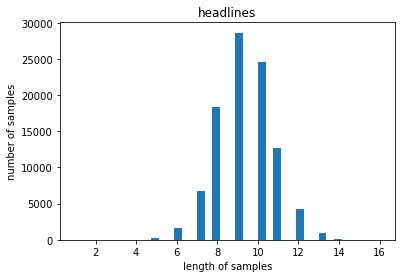

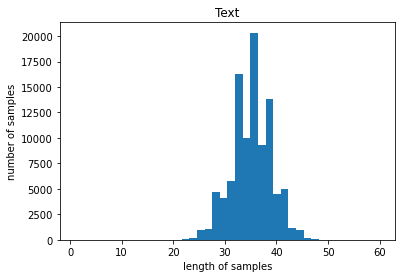

In [74]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in news['text']]
summary_len = [len(s.split()) for s in news['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(summary_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(summary_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [75]:
text_max_len = 45
summary_max_len = 13

In [76]:
below_threshold_len(text_max_len, news['text'])
below_threshold_len(summary_max_len,  news['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


In [77]:
news = news[news['text'].apply(lambda x: len(x.split()) <= text_max_len)]
news = news[news['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(news)))

전체 샘플수 : 97863


In [78]:
news['decoder_input'] = news['headlines'].apply(lambda x : 'sos '+ x)
news['decoder_target'] = news['headlines'].apply(lambda x : x + ' eos')
news.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sos upgrad learner switches to career in ml al...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sos delhi techie wins free food from swiggy fo...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sos new zealand end rohit sharma led india mat...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sos aegon life iterm insurance plan helps cust...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sos have known hirani for yrs what if metoo cl...,have known hirani for yrs what if metoo claims...


In [79]:
encoder_input = np.array(news['text'])
decoder_input = np.array(news['decoder_input']) 
decoder_target = np.array(news['decoder_target'])

In [80]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[20712  1579 50968 ... 69618  1272 83828]


In [81]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [82]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19572


In [83]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


In [84]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [85]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69219
등장 빈도가 6번 이하인 희귀 단어의 수: 47086
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22133
단어 집합에서 희귀 단어의 비율: 68.02467530591312
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.481656396035911


In [86]:
src_vocab = 20000 # 단어집합의 크기 * (1- 희귀단어의 비율)의 근사값
src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [87]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[79, 824, 1281, 198, 149, 1143, 143, 1177, 20, 44, 88, 149, 498, 15, 6, 29, 15, 543, 824, 5506, 1143, 33, 363, 2764, 1037, 818, 48, 1143, 1375, 1235, 1277], [37, 482, 2142, 104, 9, 1773, 18, 126, 2153, 1242, 182, 14, 2833, 2999, 1, 232, 2153, 378, 462, 4610, 6151, 171, 985, 985, 173, 19, 335, 389, 450, 14, 4534, 8390, 775, 3728, 4], [127, 194, 4816, 926, 1034, 99, 1406, 307, 237, 3978, 2740, 2328, 2885, 2, 99, 1406, 1249, 5913, 1491, 77, 897, 34, 649, 1271, 2023, 1698, 429, 6, 1249, 4633, 439, 897, 34, 1437, 1250, 5109, 7308, 27, 2230]]


In [88]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [89]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30045
등장 빈도가 5번 이하인 희귀 단어의 수: 19635
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10410
단어 집합에서 희귀 단어의 비율: 65.35197204193709
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.657062393833133


In [90]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 361, 110, 6495, 164, 9, 502, 14], [1, 5624, 410, 730, 730, 2162, 7, 1044, 1009, 769], [1, 159, 199, 7210, 3, 370, 515, 2390, 4, 8], [1, 730, 1729, 464, 166, 715], [1, 628, 2211, 3691, 746, 9, 58, 152]]
target
decoder  [[361, 110, 6495, 164, 9, 502, 14, 2], [5624, 410, 730, 730, 2162, 7, 1044, 1009, 769, 2], [159, 199, 7210, 3, 370, 515, 2390, 4, 8, 2], [730, 1729, 464, 166, 715, 2], [628, 2211, 3691, 746, 9, 58, 152, 2]]


In [91]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19571
테스트 레이블의 개수 : 19571


In [92]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='pre')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='pre')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='pre')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='pre')

### 3. 데이터 설계하기

In [93]:

embedding_dim = 128
hidden_size = 256


encoder_inputs = Input(shape=(text_max_len,))


enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)


encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)


encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)


encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [94]:
decoder_inputs = Input(shape=(None,))


dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)


decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [95]:
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 


model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 45, 128)      1280000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 45, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [96]:
attn_layer = AttentionLayer(name='attention_layer')

attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])


decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])


decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)


model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 45, 128)      1280000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 45, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 4. 모델 훈련하기

In [97]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
306/306 [==============================] - 104s 340ms/step - loss: 5.1873 - val_loss: 4.8571
Epoch 2/50
306/306 [==============================] - 102s 334ms/step - loss: 4.8522 - val_loss: 4.7388
Epoch 3/50
306/306 [==============================] - 102s 332ms/step - loss: 4.7315 - val_loss: 4.6365
Epoch 4/50
306/306 [==============================] - 102s 333ms/step - loss: 4.6051 - val_loss: 4.5176
Epoch 5/50
306/306 [==============================] - 102s 334ms/step - loss: 4.4806 - val_loss: 4.4495
Epoch 6/50
306/306 [==============================] - 103s 337ms/step - loss: 4.3736 - val_loss: 4.3339
Epoch 7/50
306/306 [==============================] - 104s 340ms/step - loss: 4.2853 - val_loss: 4.2889
Epoch 8/50
306/306 [==============================] - 104s 339ms/step - loss: 4.2134 - val_loss: 4.2231
Epoch 9/50
306/306 [==============================] - 102s 333ms/step - loss: 4.1495 - val_loss: 4.1824
Epoch 10/50
306/306 [==============================] - 102s 333m

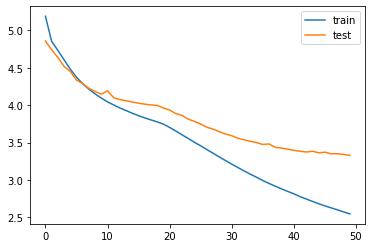

In [98]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 조금만 더 돌려보자.

In [99]:
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 20)

Epoch 1/20
306/306 [==============================] - 107s 349ms/step - loss: 2.5233 - val_loss: 3.3614
Epoch 2/20
306/306 [==============================] - 110s 359ms/step - loss: 2.5010 - val_loss: 3.3298
Epoch 3/20
306/306 [==============================] - 111s 364ms/step - loss: 2.4788 - val_loss: 3.3395
Epoch 4/20
306/306 [==============================] - 114s 374ms/step - loss: 2.4565 - val_loss: 3.3311
Epoch 00004: early stopping


### 5. 인퍼런스모델 구현하기

In [101]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [102]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [103]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [105]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eos'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eos'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 6. 모델 테스트하기

In [106]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sos']) and i!=tar_word_to_index['eos']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [108]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : hollywood actor mark accidentally live streamed portion world premiere upcoming superhero film forgot turn instagram live audio film kept playing live streamed video mark kept phone inside pocket shared live video fans event 
실제 요약 : mark accidentally part of thor 
예측 요약 :  releases pic of actor from sets of his own game in thrones


원문 : market regulator sebi friday rejected india largest engineering construction company crore share buyback regulator rejected proposal citing sharp rise debt equity ratio company buyback went government holds stake looking participate buyback raise funds 
실제 요약 : market regulator rejects crore share buyback 
예측 요약 :  pnb shares rise in last year low of profit of bn fraud


원문 : reference people criticising akshay kumar recent national award win suniel shetty said completely wrong akshay given many hits deserves honour shetty added maybe given honour looking growth years akshay first national award best actor year 
실제 요약 : akshay kumar to win nation

## 추출 요약

In [139]:
import requests
from summa.summarizer import summarize

In [140]:
news_path = os.getenv("HOME") + '/aiffel/news_summarization/data/news_summary_more.csv'
news = pd.read_csv(news_path)
news.head()
print(news.shape)
summarization_path = os.getenv('HOME') + '/aiffel/news_summarization/data/summzarization_data.txt'

(98401, 2)


In [141]:
with open(summarization_path, 'w', encoding='utf8') as f:
    f.write('\n'.join(news['text']))

In [142]:
with open(summarization_path, 'r', encoding = 'utf-8') as f:
    summarization = f.read().split('\n')

In [152]:
test = summarization[:100]

In [161]:
for text in test:
    print('Summary:')
    print(summarize(text, ratio = 0.8, words = 40))

Summary:
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.
Summary:
Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins.
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
Summary:
New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series.
The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.
Summary:
The plan provides life cover up to the age of 100 years.
Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.
Summary:
Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam

일단 추출요약이 생성요약에 비해서 퀄리티가 있고 자연스럽다.    
다만 품질을 올리기 위해서는 BERT나 ELECTRA같은 모델을 쓰면 효율성은 배가될 것이다.    